In [1]:
import csv
import cv2
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm
import itertools
from matplotlib import pyplot as plt
from math import atan2, degrees, sqrt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path of the folder that contains the entire dataset
dataset_path = '/content/drive/MyDrive/capstone/tricep dips/dataset'

# Path of the folder to store the split dataset
train_dir = '/content/drive/MyDrive/capstone/tricep dips/dataset/train'
val_dir = '/content/drive/MyDrive/capstone/tricep dips/dataset/val'
test_dir = '/content/drive/MyDrive/capstone/tricep dips/dataset/test'

# Path for each class tricep dips position
up_position_path = dataset_path + '/tricep_dips_up'
down_position_path = dataset_path + '/tricep_dips_down'

In [8]:
def split_dataset(position_path, train_dir, val_dir, test_dir):
  # Split the dataset into train and test subsets
  train_images, test_images = train_test_split(os.listdir(position_path), test_size=0.2)

  # Split the remaining train subset into train and val subsets
  train_images, val_images = train_test_split(train_images, test_size=0.25)

  # Move the images to the train, validation, and test folders
  def move_images(path_dir, images):
      for image in images:
          os.rename(os.path.join(position_path, image), os.path.join(path_dir, image))

  move_images(train_dir, train_images)
  move_images(val_dir, val_images)
  move_images(test_dir, test_images)

# Run the split_dataset function to split the dataset of each push up position.
split_dataset(up_position_path, train_dir+'/up', val_dir+'/up', test_dir+'/up')
split_dataset(down_position_path, train_dir+'/down', val_dir+'/down', test_dir+'/down')

In [9]:
# Download model from TF Hub and check out inference code from GitHub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# Apply MoveNet's cropping algorithm and run inference multiple times on the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):
  image_height, image_width, channel = input_tensor.shape

  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  # Repeatedly using previous detection result to identify the region of interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(),
                            reset_crop_region=False)

  return person

Cloning into 'examples'...
remote: Enumerating objects: 23745, done.
remote: Total 23745 (delta 0), reused 0 (delta 0), pack-reused 23745
Receiving objects: 100% (23745/23745), 44.08 MiB | 27.95 MiB/s, done.
Resolving deltas: 100% (12942/12942), done.


In [10]:
def draw_prediction_on_image(image, person, crop_region=None, close_figure=True, keep_input_size=False):
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])

  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)

  if close_figure:
    plt.close(fig)

  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [11]:
class MoveNetPreprocessor(object):
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()

    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )

  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)

      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file,
                                    delimiter=',',
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0

        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape

          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)

          # Save landmarks if all landmarks were detected
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person,
              close_figure=True, keep_input_size=True)

          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))

    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names

  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)

      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '')
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)

    list_name = [[bodypart.name + '_x', bodypart.name + '_y',
                  bodypart.name + '_score'] for bodypart in BodyPart]
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i]
                  for i in range(len(header_name))}

    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

In [14]:
def preprocess_data(path_dir, out_dir):
    images_in_folder = path_dir
    images_out_folder = out_dir
    csvs_out_path = path_dir+'/_landmark.csv'

    preprocessor = MoveNetPreprocessor(
        images_in_folder=images_in_folder,
        images_out_folder=images_out_folder,
        csvs_out_path=csvs_out_path,)
    preprocessor.process()

preprocess_data(train_dir, dataset_path+'/output_train')
preprocess_data(val_dir, dataset_path+'/output_val')
preprocess_data(test_dir, dataset_path+'/output_test')

Preprocessing down
100%|██████████| 213/213 [11:57<00:00,  3.37s/it]
Preprocessing up
100%|██████████| 207/207 [11:38<00:00,  3.37s/it]
Preprocessing down


Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/train/down/tricep dips_1000041.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/train/down/tricep dips_1000131.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/train/down/tricep dips_1000141.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/train/down/tricep dips_1000151.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/train/down/tricep dips_1000211.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/train/down/tricep dips_1000221.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/train/down/tricep dips_1000231.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/train/down/tricep dips_

100%|██████████| 82/82 [05:05<00:00,  3.73s/it]
Preprocessing up
100%|██████████| 80/80 [04:53<00:00,  3.67s/it]
Preprocessing down


Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/val/down/tricep dips_1000031.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/val/down/tricep dips_1000051.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/val/down/tricep dips_1000321.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/val/down/tricep dips_1000391.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/val/down/tricep dips_1100031.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/val/down/tricep dips_1100111.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/val/down/tricep dips_1100321.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/val/down/tricep dips_1100341.jpg. No 

100%|██████████| 50/50 [03:04<00:00,  3.70s/it]
Preprocessing up
100%|██████████| 46/46 [02:49<00:00,  3.68s/it]

Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/test/down/tricep dips_1000031.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/test/down/tricep dips_1000051.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/test/down/tricep dips_1000321.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/test/down/tricep dips_1000411.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/test/down/tricep dips_100421.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/test/down/tricep dips_1100101.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/test/down/tricep dips_1100181.jpg. No pose was confidentlly detected.
Skipped /content/drive/MyDrive/capstone/tricep dips/dataset/test/down/tricep dips_1100251.j

In [26]:
# Path file _landmark.csv tiap dataset
TRAINING_FILE = '/content/drive/MyDrive/capstone/tricep dips/dataset/train/_landmark.csv'
VALIDATION_FILE = '/content/drive/MyDrive/capstone/tricep dips/dataset/val/_landmark.csv'
TESTING_FILE = '/content/drive/MyDrive/capstone/tricep dips/dataset/test/_landmark.csv'

In [45]:
# Fungsi untuk memuat data dari file CSV dan mengabaikan kolom pertama dan terakhir
def load_data(file_path):
    dataframe = pd.read_csv(file_path)
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    classes = df_to_process.pop('class_name').unique()

    # Extract the labels
    y = df_to_process.pop('class_no')

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64').values

    return X, y, classes, dataframe

# Load train, validation, and test data
try:
    X_train, y_train, class_names, _ = load_data(TRAINING_FILE)
    X_val, y_val, class_names, _ = load_data(VALIDATION_FILE)
    X_test, y_test, class_names, _ = load_data(TESTING_FILE)
except Exception as e:
    print(f"Error loading data: {e}")

print(f"Length X_train: {len(X_train)}, X_train Shape: {X_train.shape}, Length y_train: {len(y_train)}, y_train Shape: {y_train.shape}")
print(f"Length X_val: {len(X_val)}, X_val Shape: {X_val.shape}, Length y_val: {len(y_val)}, y_val Shape: {y_val.shape}")
print(f"Length X_test: {len(X_test)}, X_test Shape: {X_test.shape}, Length y_test: {len(y_test)}, y_test Shape: {y_test.shape}")

Length X_train: 238, X_train Shape: (238, 51), Length y_train: 238, y_train Shape: (238,)
Length X_val: 92, X_val Shape: (92, 51), Length y_val: 92, y_val Shape: (92,)
Length X_test: 49, X_test Shape: (49, 51), Length y_test: 49, y_test Shape: (49,)


In [28]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center,
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [44]:
# Define the model

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(51,)),
    tf.keras.layers.Lambda(landmarks_to_embedding),
    tf.keras.layers.Dense(128, activation=tf.nn.relu6),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation=tf.nn.relu6),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 34)                0         
                                                                 
 dense_20 (Dense)            (None, 128)               4480      
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12801 (50.00 KB)
Trainable params: 12801

In [46]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=8,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
16/30 [===============>..............] - ETA: 0s - loss: 0.6899 - accuracy: 0.5234 
Epoch 1: val_accuracy improved from -inf to 0.51087, saving model to weights.best.hdf5
30/30 [==============================] - 2s 14ms/step - loss: 0.6823 - accuracy: 0.5378 - val_loss: 0.6748 - val_accuracy: 0.5109
Epoch 2/200
20/30 [===================>..........] - ETA: 0s - loss: 0.6717 - accuracy: 0.5688
Epoch 2: val_accuracy improved from 0.51087 to 0.57609, saving model to weights.best.hdf5
30/30 [==============================] - 0s 5ms/step - loss: 0.6600 - accuracy: 0.6092 - val_loss: 0.6592 - val_accuracy: 0.5761
Epoch 3/200
 1/30 [>.............................] - ETA: 0s - loss: 0.6584 - accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/30 [====================>.........] - ETA: 0s - loss: 0.6345 - accuracy: 0.6250
Epoch 3: val_accuracy improved from 0.57609 to 0.63043, saving model to weights.best.hdf5
30/30 [==============================] - 0s 5ms/step - loss: 0.6412 - accuracy: 0.6008 - val_loss: 0.6326 - val_accuracy: 0.6304
Epoch 4/200
23/30 [======================>.......] - ETA: 0s - loss: 0.6157 - accuracy: 0.7446
Epoch 4: val_accuracy improved from 0.63043 to 0.80435, saving model to weights.best.hdf5
30/30 [==============================] - 0s 7ms/step - loss: 0.6132 - accuracy: 0.7395 - val_loss: 0.5864 - val_accuracy: 0.8043
Epoch 5/200
18/30 [=================>............] - ETA: 0s - loss: 0.5710 - accuracy: 0.7639
Epoch 5: val_accuracy improved from 0.80435 to 0.86957, saving model to weights.best.hdf5
30/30 [==============================] - 0s 5ms/step - loss: 0.5620 - accuracy: 0.7731 - val_loss: 0.5304 - val_accuracy: 0.8696
Epoch 6/200
19/30 [==================>...........] - ETA: 0s - loss: 0

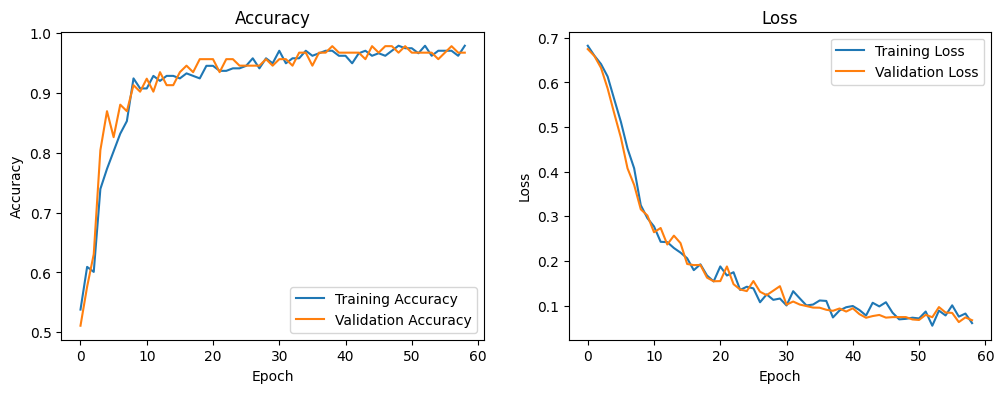

In [47]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [48]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 11ms/step - loss: 0.1274 - accuracy: 0.9796


2/2 [==============================] - 0s 6ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

     class 0       0.96      1.00      0.98        22
     class 1       1.00      0.96      0.98        27

    accuracy                           0.98        49
   macro avg       0.98      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49



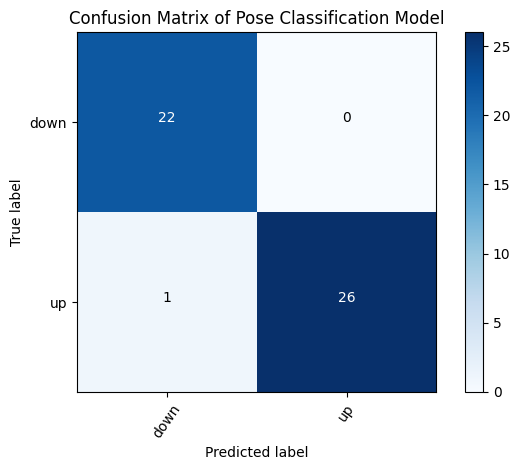

In [50]:
# confusion matrix for sigmoid
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction probabilities to class labels (0 or 1)
y_pred_label = (y_pred >= 0.5).astype(int)

y_true_label = y_test  

# Plot the confusion matrix
cm = confusion_matrix(y_true_label, y_pred_label)
plot_confusion_matrix(cm,
                      classes=['down', 'up'],
                      title='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label,
                                                          target_names=['class 0', 'class 1']))

**Save Model**

In [51]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('triceps_sigmoid.tflite', 'wb') as f:
  f.write(tflite_model)

Model size: 25KB
